# Hyperspectral image ground classification
## Using Deep Learning

In [444]:
%matplotlib inline

import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Activation, Average, Dense, Flatten
from keras.layers.convolutional import AveragePooling3D, Conv3D
from keras.models import Model
from keras.optimizers import SGD
from keras.engine.input_layer import Input
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU, ThresholdedReLU
from keras import regularizers
from keras.regularizers import l2

from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')

import numpy as np

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
import skimage as sk
from skimage import transform
from skimage import util

import scipy
import scipy.ndimage
import scipy.io as sio

import matplotlib.pyplot as plt
from matplotlib import patches
import itertools
import spectral
from spectral import spy_colors

import time
import os
import sys
import random
from random import shuffle


### Some useful functions for reuse

In [405]:

#Function found on stackoverflow
def printProgressBar (iteration, total, prefix = 'Progress: ', suffix = ' Complete', decimals = 1, length = 40, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()


def print_shape(**kwargs):
    """
    Print multiple shapes of np.ndarray
    """
    for key, value in kwargs.items():
        print ("%s: %s" %(key, value.shape))
        
def loadData():
    data_path = os.path.join(os.getcwd(),'.')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    train_labels = np.load("train_data.npy")
    test_labels = np.load("test_data.npy")
    
    return data, train_labels, test_labels

def displayPrincipalComponents(X, cmap="gray"):
    """
    Display principal components of the sensor data array
    ...
    
    Parameters
    ----------
    X : np.ndarray of dim MxNxP
        Sensor data of MxN pixels and P bands
    cmap : str, optional
        Custom color map for matplotlib
    """
    pc = spectral.principal_components(X_train)
    plt.figure()
    plt.imshow(pc.cov, cmap=cmap)
    
    return pc

def reduceComponents(X, reduce_factor=7):
    """
    Reduce aviris sensor data array in principal components
    ...
    
    Parameters
    ----------
    X : np.ndarray of dim MxNxP
        Sensor data of MxN pixels and P bands
    reduce_factor : int, optional
        Determines the strength of dimensionality reduction
    """
    switcher = {
        1: 0.9,
        2: 0.99,
        3: 0.999,
        4: 0.9999,
        5: 0.99999,
        6: 0.999999,
        7: 0.9999999
    }
    fraction = switcher.get(reduce_factor, 7)
    pc = spectral.principal_components(X).reduce(fraction=fraction)

    # How many eigenvalues are left?

    print("Reflectance bands remaining: %s" %(len(pc.eigenvalues)))
    newX = pc.transform(X)

    #v = plt.imshow(img_pc[:,:,1], cmap="cool")
    return newX

def displayImage(X, img_num=3, cmap="gray"):
    """
    Display image from sensor data array
    ...
    
    Parameters
    ----------
    X : np.ndarray of dim MxNxP
        Sensor data of MxN pixels and P bands
    img_num : int, optional
        Display band 'img_num'
    cmap : str, optional
        Custom color map for matplotlib
    """
    plt.figure()
    plt.imshow(X[:,:,img_num], cmap=cmap)
    
def patch_1dim_split(X, train_data, test_data, PATCH_SIZE):
    padding = int((PATCH_SIZE - 1) / 2) #Patch de 3*3 = padding de 1 (centre + 1 de chaque coté)
    #X_padding = np.zeros(X)
    X_padding = np.pad(X, [(padding, padding), (padding, padding), (0, 0)], mode='constant')
    
    X_patch = np.zeros((X.shape[0] * X.shape[1], PATCH_SIZE, PATCH_SIZE, X.shape[2]))
    y_train_patch = np.zeros((train_data.shape[0] * train_data.shape[1]))
    y_test_patch = np.zeros((test_data.shape[0] * test_data.shape[1]))
    
    index = 0
    for i in range(0, X_padding.shape[0] - 2 * padding):
        for j in range(0, X_padding.shape[1] - 2 * padding):
            # This condition is for less frequent updates. 
            if i % 8 == 0 or index == (X_padding.shape[0] - 2 * padding) * (X_padding.shape[1] - 2 * padding) - 1:
                printProgressBar(index + 1, (X_padding.shape[0] - 2 * padding) * (X_padding.shape[1] - 2 * padding))
            patch = X_padding[i:i + 2 * padding + 1, j:j + 2 * padding + 1]
            X_patch[index, :, :, :] = patch
            y_train_patch[index] = train_data[i, j]
            y_test_patch[index] = test_data[i, j]
            index += 1
    
    print("\nCreating train/test arrays and removing zero labels...")
    printProgressBar(1, 7)
    X_train_patch = np.copy(X_patch)
    printProgressBar(2, 7)
    X_test_patch = np.copy(X_patch)
    
    printProgressBar(3, 7)
    X_train_patch = X_train_patch[y_train_patch > 0,:,:,:]
    printProgressBar(4, 7)
    X_test_patch = X_test_patch[y_test_patch > 0,:,:,:]
    printProgressBar(5, 7)
    y_train_patch = y_train_patch[y_train_patch > 0] - 1
    printProgressBar(6, 70)
    y_test_patch = y_test_patch[y_test_patch > 0] - 1
    printProgressBar(7, 7)
    print("Done.")
    
    return X_train_patch, X_test_patch, y_train_patch, y_test_patch

def dimensionalityReduction(X, numComponents=75, standardize=True):
    if standardize:
        newX = np.reshape(X, (-1, X.shape[2]))
        scaler = preprocessing.StandardScaler().fit(newX)  
        newX = scaler.transform(newX)
        X = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


def BoostDataset(X, y, n_samples=0):
    # Techniques from 
    # https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec
    
    orig_shape = X.shape[0]
    index = orig_shape
    print("Boosting Dataset...")
    for i in range(n_samples):
        if i % 5 == 0 or i + 1 == n_samples:
            printProgressBar(i + 1, n_samples)
        num_sample = random.randint(0, orig_shape)
        patch = X[num_sample,:,:,:]
        #print(patch.shape)
        num = random.randint(0, 4)
        if (num == 0):
            new_patch = np.flipud(patch)
            
        if (num == 1):
            new_patch = np.fliplr(patch)
            
        if (num == 2):
            new_patch = sk.util.random_noise(patch)
            
        if (num == 3 or num == 4):
            random_degree = random.uniform(-25, 25)
            new_patch = sk.transform.rotate(patch, random_degree)
            
        #print(new_patch.shape)
        #time.sleep(5)
            
        X = np.append(X, [new_patch], axis=0)
        y = np.append(y, y[num_sample])
    
    return X, y

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def reports (X_test,y_test, target_names):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch



def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y == label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY


### Global variables and hyperparameters

In [406]:
numPCAcomponents = 30
PATCH_SIZE = 5
C1 = 3*numPCAcomponents

batch_size = 128
epochs = 10

target_names = ['Maïs- Pas de Technique de Conservation des sols',
                    'Maïs- Minimum Tillage',
                    'Herbe-Pâturage',
                    'Herbe-Arbre',
                    'Soja-Pas de Technique de Conservation des sols', 'Soja-Minimum Tillage','Soja', 'Bois',
                    'Bâtiment-Herbe-Arbre-drives',]

label_dictionary = {
    0: 'Rien',
    1: 'Maïs- Pas de Technique de Conservation des sols', 
    2: 'Maïs- Minimum Tillage',
    3: 'Herbe-Pâturage', 
    4: 'Herbe-Arbre', 
    5: 'Soja-Pas de Technique de Conservation des sols', 
    6: 'Soja-Minimum Tillage',
    7: 'Soja', 
    8: 'Bois', 
    9: 'Bâtiment-Herbe-Arbre-drives',
}

### Load and preprocess data according to our needs

In [573]:
X, train_data, test_data = loadData()

In [574]:
# This is essential to insure a random distribution of classes between the test / train data

def shuffleTrainTest(train, test):
    np.random.seed(42)
    for i in range(train.shape[0]):
        for j in range(train.shape[1]):
            if train[i, j] != 0 or test[i, j] != 0 :
                x = np.random.randint(1,3)
                if x == 1:
                    temp = train[i, j]
                    train[i, j] = test[i, j]
                    test[i, j] = temp
    return train, test



In [575]:
# Check random distribution and delete classes
t,v = np.unique(train_data, return_counts=True)
print(t, v)
t,v = np.unique(test_data, return_counts=True)
print(t, v)



train_data = deleteUselessClasses(train_data)
test_data = deleteUselessClasses(test_data)
train_data, test_data = shuffleTrainTest(train_data, test_data)
t,v = np.unique(train_data, return_counts=True)
print(t, v)
t,v = np.unique(test_data, return_counts=True)
print(t, v)

[ 0  2  3  5  6 10 11 12 14 15] [15155   648   751   465   492   231  1646   403  1145    89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [16646    46   780    79   237    18   238    28   478    20   741   809
   190   205   120   297    93]
[0 1 2 3 4 5 6 7 8 9] [16527   695   401   254   380   466  1207   273   637   185]
[0 1 2 3 4 5 6 7 8 9] [16381   733   429   229   350   506  1248   320   628   201]


In [576]:
X, pca = dimensionalityReduction(X, numComponents=numPCAcomponents, standardize=False)
X.shape

(145, 145, 30)

In [577]:
X = X[:,:,:100]

In [578]:
# Add padding, move patch along the array, make image one dimensional, and split provided train and test_data with removing zeros labels at the same time
# X.shape : (Pixels_in_one_band, patch_row, patch_col, reflectance_band) 
# Pixels_in_one_band.shape = 145 * 145 = 21025

X_train, X_test, y_train, y_test = patch_1dim_split(X, train_data, test_data, PATCH_SIZE)

Progress:  |████████████████████████████████████████| 100.0%  Complete

Creating train/test arrays and removing zero labels...
Progress:  |████████████████████████████████████████| 100.0%  Complete
Done.


In [579]:
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [274]:
# Add samples. Warning: 33.3s for 100 samples on my PC if no dimensionality reduction. There's room for optimization here. 
# Optimization Tip: Array is recreated at each iteration.
X_train, y_train = BoostDataset(X_train, y_train, n_samples=1000)
print(X_train.shape)
print(y_train.shape)

Boosting Dataset...
Progress:  |████████████████████████████████████████| 100.0%  Complete
(15404, 5, 5, 30)
(15404,)


In [580]:
# Check if X and y have compatible shapes (X_*.shape[0] === y_*.shape[0])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_test, y_test = oversampleWeakClasses(X_test, y_test)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(11269, 5, 5, 30)
(11269,)
(4644, 5, 5, 30)
(4644,)
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([1390, 1203, 1270, 1140, 1398, 1207, 1092, 1274, 1295]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([1466, 1287, 1145, 1400, 1012, 1248, 1280, 1256, 1206]))


In [581]:
#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], X_test.shape[1], X_test.shape[2]))

y_train = np_utils.to_categorical(y_train, num_classes=9)
y_test = np_utils.to_categorical(y_test, num_classes=9)

In [582]:
input_shape= X_train[0].shape
print(input_shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5, 5, 30)
(11269, 5, 5, 30)
(11269, 9)
(11300, 5, 5, 30)
(11300, 9)


In [583]:
def sequential_cnn_model(input_shape, optimizer='adam'):
    model = Sequential()
    
    model.add(Conv2D(C1, (3,3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(3*C1, (3,3), activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(AveragePooling2D(pool_size=(1, 1), strides=(1, 1)))
    model.add(Flatten())
    model.add(Dense(30*numPCAcomponents, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])
    return model

#model = KerasClassifier(build_fn=create_model, verbose=0)
sequential_cnn_model = sequential_cnn_model(input_shape)

# On a 9 classes en réalité, donc une accuracy > 100/9 ~=11.11 est supérieure au hasard. 
sequential_cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1)

Epoch 1/5
11269/11269 [==============================] - 4s 386us/step - loss: 1.6306 - acc: 0.4572
Epoch 2/5
11269/11269 [==============================] - 2s 182us/step - loss: 0.7869 - acc: 0.7088
Epoch 3/5
11269/11269 [==============================] - 2s 185us/step - loss: 0.5220 - acc: 0.8168
Epoch 4/5
11269/11269 [==============================] - 2s 197us/step - loss: 0.3660 - acc: 0.8752
Epoch 5/5
11269/11269 [==============================] - 2s 183us/step - loss: 0.2667 - acc: 0.9131


In [ ]:
from keras.layers.merge import concatenate
from keras.layers.core import Reshape

def bn_prelu(input):
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    # return Activation("relu")(norm)
    return PReLU()(norm)


def spectral_conv(input):
    activation = bn_prelu(input)
    conv = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 1), kernel_regularizer=l2(0.0001),
                  filters=growth_rate, kernel_size=(1, 1, 7), padding='same', dilation_rate=(1, 1, 1))(activation)
    return conv


def spatial_conv(input):
    activation = bn_prelu(input)
    conv = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 1), kernel_regularizer=l2(0.0001),
                  filters=growth_rate, kernel_size=(3, 3, 1), padding='same', dilation_rate=(1, 1, 1))(activation)
    return conv


def _handle_dim_ordering():
    global CONV_DIM1
    global CONV_DIM2
    global CONV_DIM3
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        CONV_DIM1 = 1
        CONV_DIM2 = 2
        CONV_DIM3 = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        CONV_DIM1 = 2
        CONV_DIM2 = 3
        CONV_DIM3 = 4


class fdssc_model(object):
    @staticmethod
    def build(input_shape, num_outputs):
        global growth_rate
        growth_rate = 12
        _handle_dim_ordering()
        if len(input_shape) != 4:
            raise Exception("Input shape should be a tuple (nb_channels, kernel_dim1, kernel_dim2, kernel_dim3)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[3], input_shape[0])

        input = Input(shape=input_shape)
        print("the dim of input:", input._keras_shape[3])
        # Dense spectral block

        x1_0 = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 2), kernel_regularizer=regularizers.l2(0.0001),
                      filters=24, kernel_size=(1, 1, 7), padding='valid')(input)
        x1_1 = spectral_conv(x1_0)
        x1_1_ = concatenate([x1_0, x1_1], axis=CHANNEL_AXIS)
        x1_2 = spectral_conv(x1_1_)
        x1_2_ = concatenate([x1_0, x1_1, x1_2], axis=CHANNEL_AXIS)
        x1_3 = spectral_conv(x1_2_)
        x1 = concatenate([x1_0, x1_1, x1_2, x1_3], axis=CHANNEL_AXIS)
        x1 = bn_prelu(x1)

        print('the output of dense spectral block:', x1._keras_shape)

        # Reducing dimension layer
        # x1 = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 1), kernel_regularizer=regularizers.l2(0.0001),
        #            filters=24, kernel_size=(1, 1, 1), padding='valid')(x1)
        tran1 = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 1), kernel_regularizer=regularizers.l2(0.0001),
                       filters=200, kernel_size=(1, 1, x1._keras_shape[CONV_DIM3]), padding='valid')(x1)
        print(tran1._keras_shape)
        tran1 = bn_prelu(tran1)
        tran2 = Reshape((tran1._keras_shape[CONV_DIM1], tran1._keras_shape[CONV_DIM2],
                         tran1._keras_shape[CHANNEL_AXIS], 1))(tran1)

        x2_0 = Conv3D(kernel_initializer='he_normal', strides=(1, 1, 1), kernel_regularizer=regularizers.l2(0.0001),
                      filters=24, kernel_size=(3, 3, 200), padding='valid')(tran2)
        print('the input of dense spatial block:', x2_0._keras_shape)

        # Dense spatial block
        x2_1 = spatial_conv(x2_0)
        x2_1_ = concatenate([x2_0, x2_1], axis=CHANNEL_AXIS)
        x2_2 = spatial_conv(x2_1_)
        x2_2_ = concatenate([x2_0, x2_1, x2_2], axis=CHANNEL_AXIS)
        x2_3 = spatial_conv(x2_2_)
        x2 = concatenate([x2_0, x2_1, x2_2, x2_3], axis=CHANNEL_AXIS)

        print('the output of dense spectral block is:', x2._keras_shape)
        x2 = bn_prelu(x2)

        # Classifier block
        pool1 = AveragePooling3D(pool_size=(x2._keras_shape[1], x2._keras_shape[2], 1), strides=(1, 1, 1))(x2)

        flatten1 = Flatten()(pool1)
        drop1 = Dropout(0.5)(flatten1)
        dense = Dense(units=num_outputs, activation="softmax", kernel_initializer="glorot_normal")(drop1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_fdssc(input_shape, num_outputs):
        return fdssc_model.build(input_shape, num_outputs)

model = fdssc_model.build_fdssc((1, 5, 5, 30), 9)
model.compile(loss="categorical_crossentropy", optimizer="sgd")
model.summary()

In [ ]:
model.fit(
        X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1), y_train,
        batch_size=batch_size, epochs=1, shuffle=True)

In [ ]:
def nin_cnn():
    model = Sequential()
    #mlpconv block 1
    model.add(Conv2D(32, (5, 5), activation='relu',padding='valid', input_shape=input_shape))
    model.add(Conv2D(32, (1, 1), activation='relu'))
    model.add(Conv2D(32, (1, 1), activation='relu'))
    model.add(MaxPooling2D((1,1), dim_ordering="th"))
    model.add(Dropout(0.5))
    
    #mlpconv block2
    model.add(Conv2D(64, (1, 1), activation='relu',padding='valid'))
    model.add(Conv2D(64, (1, 1), activation='relu'))
    model.add(Conv2D(64, (1, 1), activation='relu'))
    model.add(MaxPooling2D((1,1), dim_ordering="th"))
    model.add(Dropout(0.5))
    
    #mlpconv block3
    model.add(Conv2D(128, (1, 1), activation='relu',padding='valid'))
    model.add(Conv2D(32, (1, 1), activation='relu'))
    model.add(Conv2D(16, (1, 1)))
    
    model.add(GlobalAveragePooling2D())
    model.add(Activation(activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nin_cnn = nin_cnn()
nin_cnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1)

In [584]:
# def evaluate_error(model):
#     pred = model.predict(X_test, batch_size = 32)
#     pred = np.argmax(pred, axis=1)
#     pred = np.expand_dims(pred, axis=1) # make same shape as y_test
#     error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]    
#     return error

# def ensemble(models, model_input):
    
#     outputs = [model.outputs[0] for model in models]
#     y = Average()(outputs)
#     model = Model(model_input, y, name='ensemble')
    
#     return model

# models = [nin_cnn, sequential_cnn_model]

# ensemble_model = ensemble(models, input_shape)

# print(evaluate_error(sequential_cnn_model))
# print(evaluate_error(nin_cnn))
model = sequential_cnn_model

In [ ]:
# mlb = MultiLabelBinarizer(classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# y_enc = mlb.fit_transform(y_train)
# clf2 = LogisticRegression()
# print(y_enc)
# voting = VotingClassifier(estimators=[('cnn', model), ('lr', clf2)], weights=[1.0, 1.0])
# voting.fit(X_train, y_enc)

In [585]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test, target_names)

11300/11300 [==============================] - 3s 254us/step


In [586]:
print(classification)

                                                 precision    recall  f1-score   support

Maïs- Pas de Technique de Conservation des sols       0.80      0.87      0.84      1466
                          Maïs- Minimum Tillage       0.91      0.88      0.89      1287
                                 Herbe-Pâturage       1.00      0.98      0.99      1145
                                    Herbe-Arbre       0.99      0.99      0.99      1400
 Soja-Pas de Technique de Conservation des sols       0.88      0.88      0.88      1012
                           Soja-Minimum Tillage       0.82      0.75      0.78      1248
                                           Soja       0.92      0.94      0.93      1280
                                           Bois       0.99      0.99      0.99      1256
                    Bâtiment-Herbe-Arbre-drives       0.97      1.00      0.98      1206

                                    avg / total       0.92      0.92      0.92     11300



Normalized confusion matrix


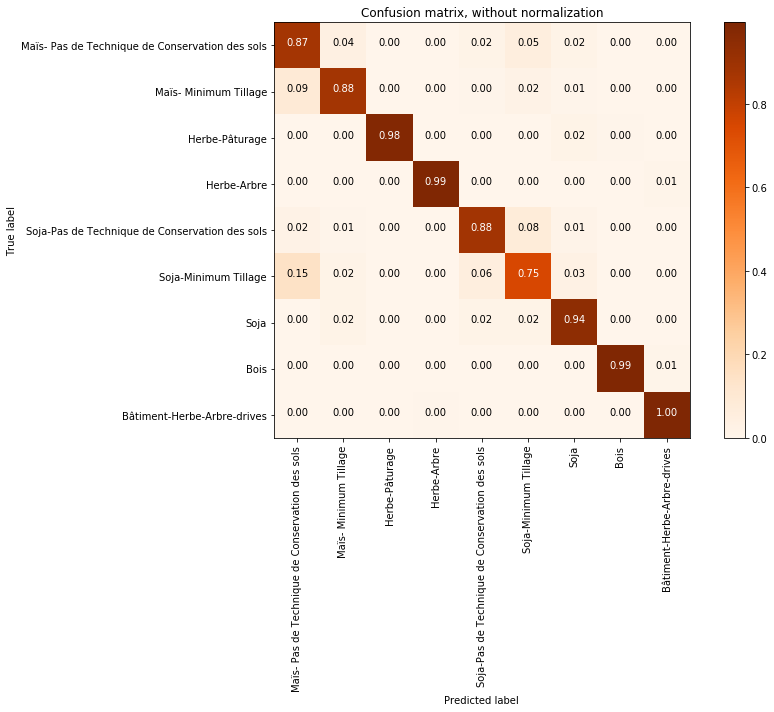

In [587]:
plt.figure(figsize=(13, 10))
plot_confusion_matrix(confusion, classes=target_names,
                      title='Confusion matrix, without normalization')

In [522]:
X_garbage, train_data, test_data = loadData()
#X = dimensionalityReduction(X, )
y = np.add(train_data, test_data)
y = deleteUselessClasses(y)

In [523]:
height = y.shape[0]
width = y.shape[1]
print(width, height)

# calculate the predicted image
outputs = np.zeros((height,width)) # zeroed image
index = 0
for i in range(0, height-PATCH_SIZE+1):
    if i % 8 == 0 or index == (height-PATCH_SIZE+1) - 1:
        printProgressBar(index + 1, (height-PATCH_SIZE+1) )
    index += 1
    for j in range(0, width-PATCH_SIZE+1):
        target = int(y[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1, image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')#.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = prediction + 1

145 145
Progress:  |████████████████████████████████████████| 100.0%  Complete


[0 1 2 3 4 5 6 7 8 9]


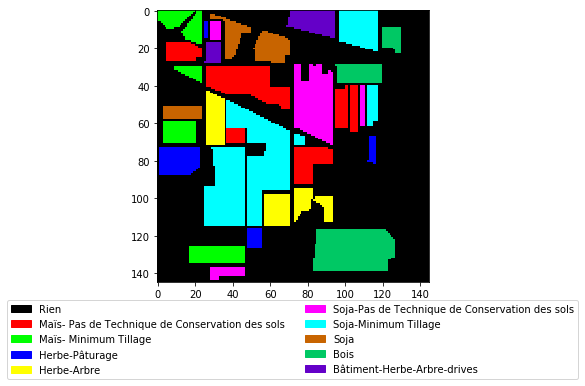

In [524]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))
print(np.unique(y))

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=label_dictionary[x]) for x in np.unique(y) ]
plt.legend(handles=labelPatches, ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));

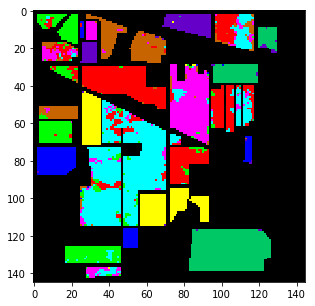

In [525]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))